<ipython-input-12-affcdf2baddc>:58: RuntimeWarning: divide by zero encountered in log10
  ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel


timebins:  89986
freqbins:  513


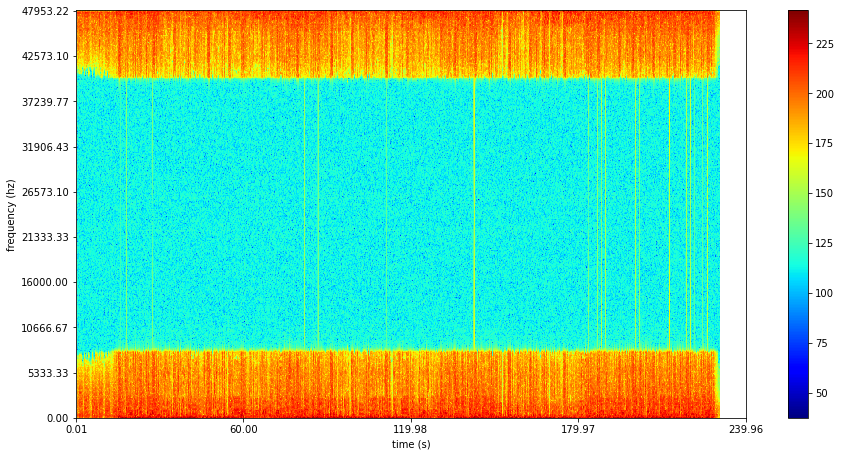

<Figure size 432x288 with 0 Axes>

In [12]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
from numpy.lib import stride_tricks

""" short time fourier transform of audio signal """
def stft(sig, frameSize, overlapFac=0.5, window=np.hanning):
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))

    # zeros at beginning (thus center of 1st window should be for sample nr. 0)   
    samples = np.append(np.zeros(int(np.floor(frameSize/2.0))), sig)    
    # cols for windowing
    cols = np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1
    # zeros at end (thus samples can be fully covered by frames)
    samples = np.append(samples, np.zeros(frameSize))

    frames = stride_tricks.as_strided(samples, shape=(int(cols), frameSize), strides=(samples.strides[0]*hopSize, samples.strides[0])).copy()
    frames *= win

    return np.fft.rfft(frames)    

""" scale frequency axis logarithmically """    
def logscale_spec(spec, sr=44100, factor=20.):
    timebins, freqbins = np.shape(spec)

    scale = np.linspace(0, 1, freqbins) ** factor
    scale *= (freqbins-1)/max(scale)
    scale = np.unique(np.round(scale))

    # create spectrogram with new freq bins
    newspec = np.complex128(np.zeros([timebins, len(scale)]))
    for i in range(0, len(scale)):        
        if i == len(scale)-1:
            newspec[:,i] = np.sum(spec[:,int(scale[i]):], axis=1)
        else:        
            newspec[:,i] = np.sum(spec[:,int(scale[i]):int(scale[i+1])], axis=1)

    # list center freq of bins
    allfreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./sr)[:freqbins+1])
    freqs = []
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            freqs += [np.mean(allfreqs[int(scale[i]):])]
        else:
            freqs += [np.mean(allfreqs[int(scale[i]):int(scale[i+1])])]

    return newspec, freqs

""" plot spectrogram"""
def plotstft(audiopath, binsize=2**10, plotpath=None, colormap="jet"):
    samplerate, samples = wav.read(audiopath)

    s = stft(samples, binsize)

    sshow, freq = logscale_spec(s, factor=1.0, sr=samplerate)

    ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel

    timebins, freqbins = np.shape(ims)

    print("timebins: ", timebins)
    print("freqbins: ", freqbins)

    plt.figure(figsize=(15, 7.5))
    plt.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap=colormap, interpolation="none")
    plt.colorbar()

    plt.xlabel("time (s)")
    plt.ylabel("frequency (hz)")
    plt.xlim([0, timebins-1])
    plt.ylim([0, freqbins])

    xlocs = np.float32(np.linspace(0, timebins-1, 5))
    plt.xticks(xlocs, ["%.02f" % l for l in ((xlocs*len(samples)/timebins)+(0.5*binsize))/samplerate])
    ylocs = np.int16(np.round(np.linspace(0, freqbins-1, 10)))
    plt.yticks(ylocs, ["%.02f" % freq[i] for i in ylocs])

    if plotpath:
        plt.savefig(plotpath, bbox_inches="tight")
    else:
        plt.show()

    plt.clf()

    return ims

ims = plotstft('Inna Ft Daddy Yankee More than Friends (Letra) (online-audio-converter.com).wav')

In [3]:
import os
import matplotlib.pyplot as plt

In [4]:
import librosa
import librosa.display

In [9]:
import IPython.display as ipd
from IPython.display  import Audio

In [13]:
ruta_prog = 'D:\Desarrollo\TEyMD_Mineria\Proyecto\prog'
pistas = os.listdir(ruta_prog)
ruta_prog
print('pistas de prog: ', len(pistas))

pistas de prog:  130


In [14]:
ruta_prog

'D:\\Desarrollo\\TEyMD_Mineria\\Proyecto\\prog'

In [7]:
pistas

['01 A Nightmare To Remember_02m_00s__.wav',
 "01 A Tap Dancer's Dilemma_02m_00s__0.wav",
 '01 Acid Rain_02m_00s__03m_00s.wav',
 '01 Balrog Boogie_02m_00s__03m_00s.wav',
 "01 C'est la Vie_02m_00s__03m_00s.wav",
 '01 Clarity_02m_00s__03m_00s.wav',
 '01 Elephant Talk_02m_00s__03m_00s.wav',
 '01 Jigsaw Hustle_02m_00s__03m_00s.wav',
 '01 Metropolis, Pt. 1 The Miracle and.wav',
 '01 Neal And Jack And Me_02m_00s__03m.wav',
 '01 Red_02m_00s__03m_00s.wav',
 '01 Stinkfist_02m_00s__03m_00s.wav',
 '01 The Glass Prision_02m_00s__03m_00.wav',
 '01 The Grudge_02m_00s__03m_00s.wav',
 '01 Vicarious_00m_00s__01m_00s.wav',
 '01 Vicarious_02m_00s__03m_00s.wav',
 '01 Vicarious_04m_00s__05m_00s.wav',
 '01 Voodoo Mon Amour_02m_00s__03m_00s.wav',
 '02 A Rancid Romance_02m_00s__03m_00s.wav',
 '02 A Rite Of Passage_02m_00s__03m_00.wav',
 '02 Dogs_02m_00s__03m_00s.wav',
 '02 Dogs_04m_00s__05m_00s.wav',
 '02 Dogs_05m_00s__06m_00s.wav',
 '02 Drumhead Trial_02m_00s__03m_00s.wav',
 '02 Eulogy_02m_00s__03m_00s.wav',

In [37]:
samples , sampling_rate = librosa.load(ruta_prog + '\\' + pistas[129], sr = None, mono = True, offset = 0.0, duration = None)
len(samples), samplig_rate

(479577, 8000)

In [38]:
samples

array([ 0.03515625, -0.04296875, -0.0859375 , ...,  0.15625   ,
        0.12109375,  0.109375  ], dtype=float32)

In [39]:
Audio(ruta_prog + '\\' + pistas[129])

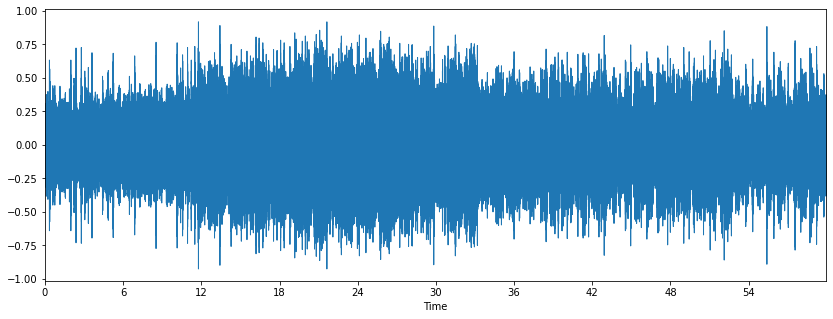

In [40]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(samples, sr=samplig_rate)

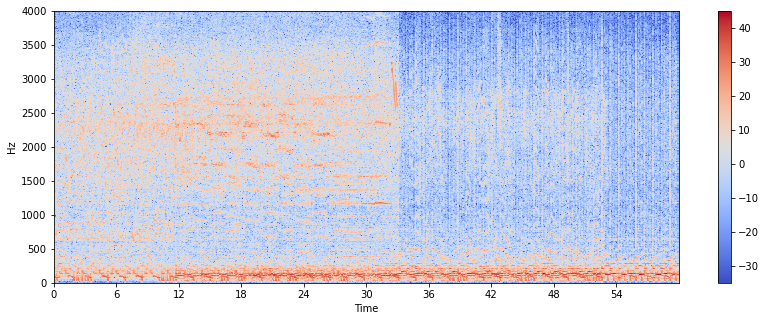

In [41]:
X = librosa.stft(samples)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar()

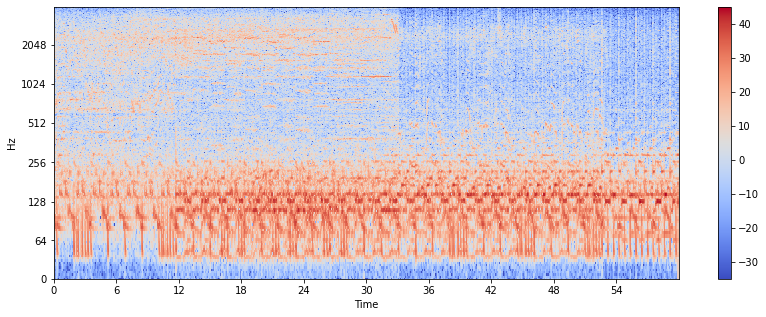

In [42]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=samplig_rate, x_axis='time', y_axis='log')
plt.colorbar()